# Import libs

In [312]:
import reservoirpy as rpy
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from reservoirpy.nodes import Ridge, Reservoir
from reservoirpy.datasets import rossler, henon_map, rabinovich_fabrikant, to_forecasting
from sklearn.linear_model import Ridge as Ridge_sklearn
from chaos_indic import HurstTraj, NoiseFactor, DimEmb, max_lyapunov, fourier_harmonic_count, ks_entropy_partition
import matplotlib.pyplot as plt
import pandas as pd

rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(23)  # make everything reproducible!

In [347]:
from sklearn.linear_model import Ridge as Ridge_sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

class EnhancedESN_FAN:
    def __init__(self,
                 input_dim,
                 reservoir_size=100,
                 spectral_radius=0.9,
                 sparsity=0.1,
                 ridge_alpha=1.0,
                 poly_order=2,
                 fan_dp=5,
                 seed=23):
        """
        input_dim : dimensionality of X (features per timestep)
        fan_dp    : number of Fourier terms (dp in the FAN paper)
        """
        np.random.seed(seed)
        self.reservoir_size = reservoir_size
        self.poly = PolynomialFeatures(degree=poly_order, include_bias=False)
        self.fan_dp = fan_dp

        # placeholders; actual Win/W init happens in fit()
        self.Win = None
        self.W   = None

        self.spectral_radius = spectral_radius
        self.sparsity = sparsity

        self.ridge = Ridge_sklearn(alpha=ridge_alpha)
        self.scaler = StandardScaler()
        self.input_scaler = StandardScaler()

    def initialize_weights(self, X):
        # input‐distribution aware Win
        inp_mean, inp_std = X.mean(axis=0), X.std(axis=0)
        mu, sigma = inp_mean.mean(), inp_std.mean()
        self.Win = np.random.normal(mu, sigma, (self.reservoir_size, X.shape[1] + 1))

        # sparse W with spectral radius
        W = np.random.rand(self.reservoir_size, self.reservoir_size) - 0.5
        W[np.random.rand(*W.shape) > self.sparsity] = 0
        W *= self.spectral_radius / np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W

    def _update(self, state, u):
        # standard ESN update
        pre = self.Win @ np.concatenate(([1], u)) + self.W @ state
        return np.tanh(pre)

    def _fourier_features(self, X):
        # X: (n_samples, n_features)
        # return: (n_samples, 2*fan_dp*n_features)
        # FAN: explicit Fourier series terms sin(2πk x), cos(2πk x)
        features = []
        for k in range(1, self.fan_dp + 1):
            features.append(np.sin(2 * np.pi * k * X))
            features.append(np.cos(2 * np.pi * k * X))
        return np.hstack(features)
    
    # def _fft_features(self, X, n_coeffs):
    #     # X: (T, n) time series
    #     # return first n_coeffs magnitudes per dimension
    #     coeffs = np.abs(fft(X, axis=0))[:n_coeffs]  # shape (n_coeffs, n)
    #     return np.tile(coeffs.flatten(), (X.shape[0], 1))

    def fit(self, X, y):
        """
        X: shape (T, input_dim)
        y: shape (T,) or (T, output_dim)
        """
        # init reservoir
        self.initialize_weights(X)

        # collect reservoir states
        T = X.shape[0]
        states = np.zeros((T, self.reservoir_size))
        state = np.zeros(self.reservoir_size)
        for t in range(T):
            state = self._update(state, X[t])
            states[t] = state

        X_scaled = self.input_scaler.fit_transform(X)
        # polynomial features
        P = self.poly.fit_transform(X_scaled)
        # Fourier analysis network features
        F = self._fourier_features(X_scaled)

        # # combine all
        # H = np.hstack([states, P, F])

        # # scale & fit readout
        # Hs = self.scaler.fit_transform(H)
        # self.ridge.fit(Hs, y)

        H = np.hstack([states, P, F])
        self.scaler.fit(H)
        # prevent division by zero in .transform()
        self.scaler.scale_[self.scaler.scale_ == 0.0] = 1.0
        Hs = self.scaler.transform(H)
        self.ridge.fit(Hs, y)


    def predict(self, X, generative_steps=None):
        """
        If X is (T, input_dim) and generative_steps is None, this is open-loop:
          returns readout(X)
        If generative_steps is an int > 0, we perform:
          - use X[-1] as u0, then recursively predict next u's.
        """
        if generative_steps is None:
            # one‐shot prediction (teacher forcing)
            T = X.shape[0]
            states = np.zeros((T, self.reservoir_size))
            state = np.zeros(self.reservoir_size)
            for t in range(T):
                state = self._update(state, X[t])
                states[t] = state

            P = self.poly.transform(X)
            F = self._fourier_features(X)
            H = np.hstack([states, P, F])
            Hs = self.scaler.transform(H)
            return self.ridge.predict(Hs)

        # generative forecasting
        u = X[-1].copy()      # last observed input
        state = np.zeros(self.reservoir_size)
        preds = []
        for _ in range(generative_steps):
            state = self._update(state, u.reshape(-1))
            # build feature row
            # P = self.poly.transform(u.reshape(1, -1))
            # F = self._fourier_features(u.reshape(1, -1))
            u_scaled = self.input_scaler.transform(u.reshape(1, -1))
            clip = 3.0  # you can tune this (e.g. 3 standard deviations)
            u_scaled = np.clip(u_scaled, -clip, clip)

            P = self.poly.transform(u_scaled)
            F = self._fourier_features(u_scaled)
            h = np.hstack([state, P.ravel(), F.ravel()]).reshape(1, -1)
            h_s = self.scaler.transform(h)
            u_next = self.ridge.predict(h_s)
            preds.append(u_next.ravel())
            u = u_next  # feed back

        return np.vstack(preds)

In [320]:
units = 200
leak_rate = 0.9
spectral_radius = 0.99
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 23

def reset_esn():
    reservoir = Reservoir(units, seed=seed)

    readout = Ridge(ridge=regularization)

    return reservoir >> readout

In [321]:
def train_test(x, test_step):
    X_train = x[:-test_step-1]
    Y_train = x[1:-test_step]
    y_test = x[-test_step:]

    return X_train, Y_train, y_test

# Rossler

In [322]:
rossler_attractor = rossler(n_timesteps=5000, h=0.2)

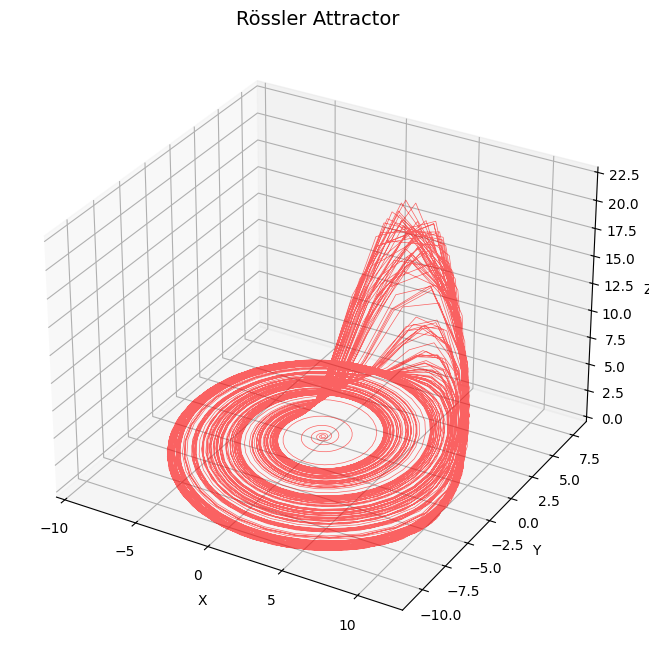

In [323]:
# Визуализация
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(rossler_attractor[:, 0], rossler_attractor[:, 1], rossler_attractor[:, 2], 'r-', lw=0.5, alpha=0.6)
ax.set_title("Rössler Attractor", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

Text(0.5, 1.0, 'Time-series of Rössler Attractor')

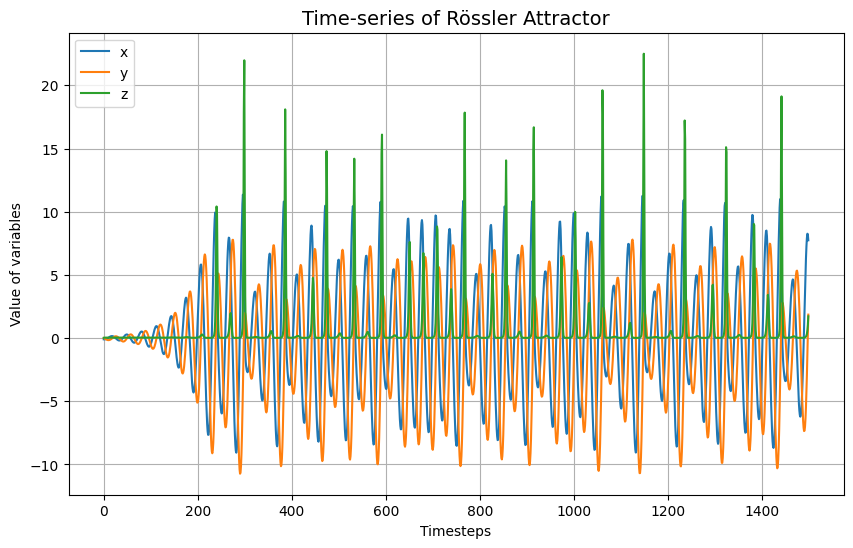

In [324]:
plt.figure(figsize=(10,6))
plt.plot(rossler_attractor[:1500, 0], label='x')
plt.plot(rossler_attractor[:1500, 1], label='y')
plt.plot(rossler_attractor[:1500, 2], label='z')
plt.xlabel('Timesteps')
plt.ylabel('Value of variables')
plt.grid()
plt.legend()
plt.title('Time-series of Rössler Attractor', fontsize=14)

In [ ]:
import pandas as pd

measures = ['Hurst', 'Noise', 'Correlation Dim', 'Lyapunov', 'KS Entropy', 'Fourier']
data = {
    'Measure': measures,
    'Variable X': [
        HurstTraj(rossler_attractor[:, 0])[2],
        NoiseFactor(rossler_attractor[:, 0]),
        DimEmb(rossler_attractor[:, 0])[1],
        max_lyapunov(rossler_attractor[:, 0]),
        ks_entropy_partition(rossler_attractor[:, 0]),
        fourier_harmonic_count(rossler_attractor[:, 0])
    ],
    'Variable Y': [
        HurstTraj(rossler_attractor[:, 1])[2],
        NoiseFactor(rossler_attractor[:, 1]),
        DimEmb(rossler_attractor[:, 1])[1],
        max_lyapunov(rossler_attractor[:, 1]),
        ks_entropy_partition(rossler_attractor[:, 1]),
        fourier_harmonic_count(rossler_attractor[:, 1])
    ],
    'Variable Z': [
        HurstTraj(rossler_attractor[:, 2])[2],
        NoiseFactor(rossler_attractor[:, 2]),
        DimEmb(rossler_attractor[:, 2])[1],
        max_lyapunov(rossler_attractor[:, 2]),
        ks_entropy_partition(rossler_attractor[:, 2]),
        fourier_harmonic_count(rossler_attractor[:, 2])
    ]
} 

df = pd.DataFrame(data)
df

,Measure,Variable X,Variable Y,Variable Z
0,Hurst,0.709291,0.727513,0.703875
1,Noise,0.861429,0.886712,0.453081
2,Correlation Dim,1.606014,1.632286,1.107217
3,Lyapunov,0.025538,0.024589,0.023903
4,KS Entropy,10.235350,9.969954,10.056151
5,Fourier,448.000000,333.000000,680.000000


## Prediction

In [325]:
X_train_rossler, Y_train_rossler, y_test_rossler = train_test(rossler_attractor, 100)

In [316]:
# from lightgbm import LGBMRegressor
# lgbm_PRED_1 = []
# lgbm_PRED_2 = []
# lgbm_PRED_3 = []

# lgbm = LGBMRegressor(seed=23)
# lgbm.fit(X_train_rossler[500:, 2].reshape(-1,1), Y_train_rossler[500:, 2].reshape(-1,1))

# cur = Y_train_rossler[-1, 1].reshape(1, -1)

# for i in range(len(y_test_rossler)):
#     cur = lgbm.predict(cur).reshape(1, -1)
#     lgbm_PRED.append(cur.flatten())

# # # esn_preds = np.vstack(esn_preds)

In [317]:
# round(mean_absolute_error(y_test_rossler[:,2], lgbm_PRED)*100, 2)

In [318]:
# plt.plot(y_test_rossler[:, 0], color='blue')
# plt.plot(y_test_rossler[:, 1], color='orange')
# plt.plot(y_test_rossler[:, 2], color='green')

In [398]:
esn_preds = []
esn = reset_esn()

esn.fit(X_train_rossler[500:], Y_train_rossler[500:])

cur = Y_train_rossler[-1]

for i in range(len(y_test_rossler)):
    cur = esn.run(cur).flatten()
    esn_preds.append(cur.flatten())

esn_preds = np.vstack(esn_preds)

In [403]:
esn_fan = EnhancedESN_FAN(input_dim=3, reservoir_size=300, spectral_radius=0.9,
                      sparsity=0.5, ridge_alpha=1e-2, poly_order=3, fan_dp=7, seed=23)
esn_fan.fit(X_train_rossler[500:], Y_train_rossler[500:])

# generative forecast
esn_fan_preds = esn_fan.predict(Y_train_rossler, generative_steps=len(y_test_rossler))

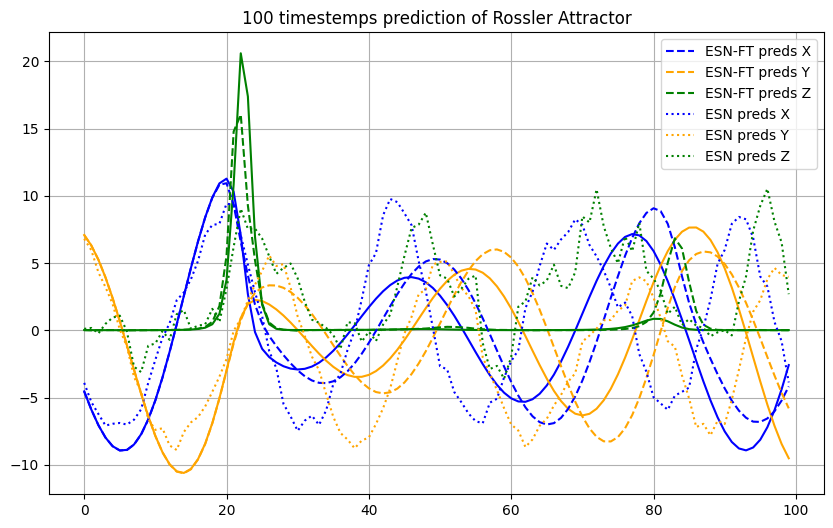

In [387]:
plt.figure(figsize=(10,6))
# real
plt.plot(y_test_rossler[:, 0], color='blue')
plt.plot(y_test_rossler[:, 1], color='orange')
plt.plot(y_test_rossler[:, 2], color='green')

# esn-f preds
plt.plot(esn_fan_preds[:, 0], label='ESN-FT preds X', ls='--', color='blue')
plt.plot(esn_fan_preds[:, 1], label='ESN-FT preds Y', ls='--', color='orange')
plt.plot(esn_fan_preds[:, 2], label='ESN-FT preds Z', ls='--', color='green')

# esn preds
plt.plot(esn_preds[:, 0], label='ESN preds X', ls=':', color='blue')
plt.plot(esn_preds[:, 1], label='ESN preds Y', ls=':', color='orange')
plt.plot(esn_preds[:, 2], label='ESN preds Z', ls=':', color='green')

plt.title('100 timestemps prediction of Rossler Attractor')
plt.grid()
plt.legend()

In [223]:
rossler_df = pd.DataFrame()

In [350]:
print(f'MAPE X - {round(mean_absolute_percentage_error(y_test_rossler[:, 0], esn_preds[:, 0])*100, 2)}, MAE - {round(mean_absolute_error(y_test_rossler[:, 0], esn_preds[:, 0]), 2)}')
print(f'MAPE Y - {round(mean_absolute_percentage_error(y_test_rossler[:, 1], esn_preds[:, 1])*100, 2)}, MAE - {round(mean_absolute_error(y_test_rossler[:, 1], esn_preds[:, 1]), 2)}')
print(f'MAPE Z - {round(mean_absolute_percentage_error(y_test_rossler[:, 2], esn_preds[:, 2])*100, 2)}, MAE - {round(mean_absolute_error(y_test_rossler[:, 2], esn_preds[:, 2]), 2)}')

MAPE X - 913.13, MAE - 4.68
MAPE Y - 222.72, MAE - 4.07
MAPE Z - 8745.8, MAE - 3.12


In [351]:
print(f'MAPE X - {round(mean_absolute_percentage_error(y_test_rossler[:, 0], esn_fan_preds[:, 0])*100, 2)}, MAE - {round(mean_absolute_error(y_test_rossler[:, 0], esn_fan_preds[:, 0]), 2)}')
print(f'MAPE Y - {round(mean_absolute_percentage_error(y_test_rossler[:, 1], esn_fan_preds[:, 1])*100, 2)}, MAE - {round(mean_absolute_error(y_test_rossler[:, 1], esn_fan_preds[:, 1]), 2)}')
print(f'MAPE Z - {round(mean_absolute_percentage_error(y_test_rossler[:, 2], esn_fan_preds[:, 2])*100, 2)}, MAE - {round(mean_absolute_error(y_test_rossler[:, 2], esn_fan_preds[:, 2]), 2)}')

# round(mean_absolute_percentage_error(y_test_rossler[:30], esn_fan_preds[:30])*100,2)

MAPE X - 545.71, MAE - 1.81
MAPE Y - 303.64, MAE - 1.93
MAPE Z - 200.68, MAE - 0.48


# Henon Map

In [352]:
henon = henon_map(n_timesteps=5000)
henon.shape

(5000, 2)

Text(0, 0.5, 'Y')

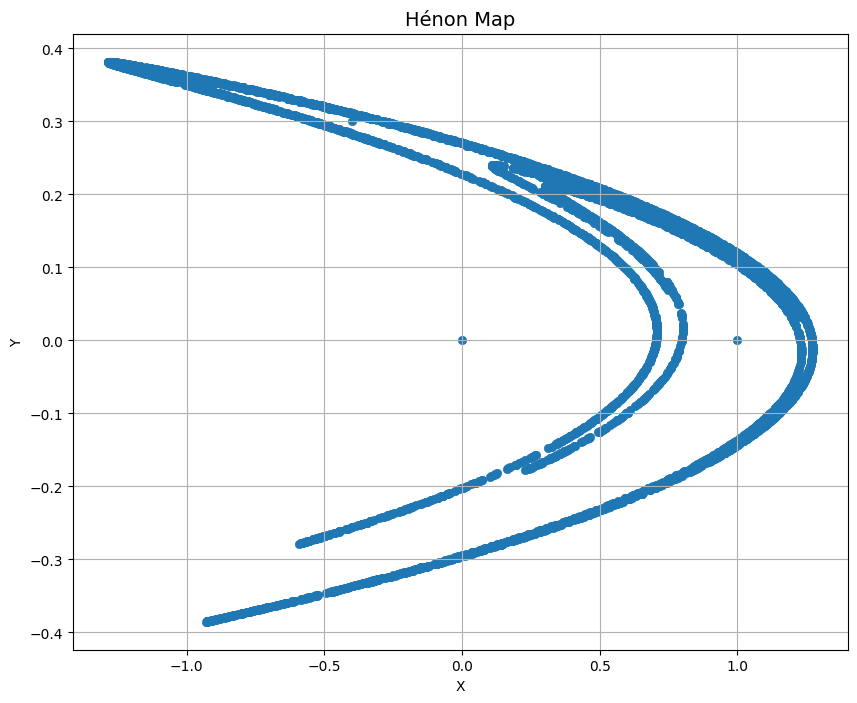

In [353]:
plt.figure(figsize=(10, 8))
plt.scatter(henon[:, 0], henon[:, 1], linewidths=0.5)
plt.title("Hénon Map", fontsize=14)
plt.grid()
plt.xlabel("X")
plt.ylabel("Y")

Text(0.5, 1.0, 'Time-series of Hénon Map')

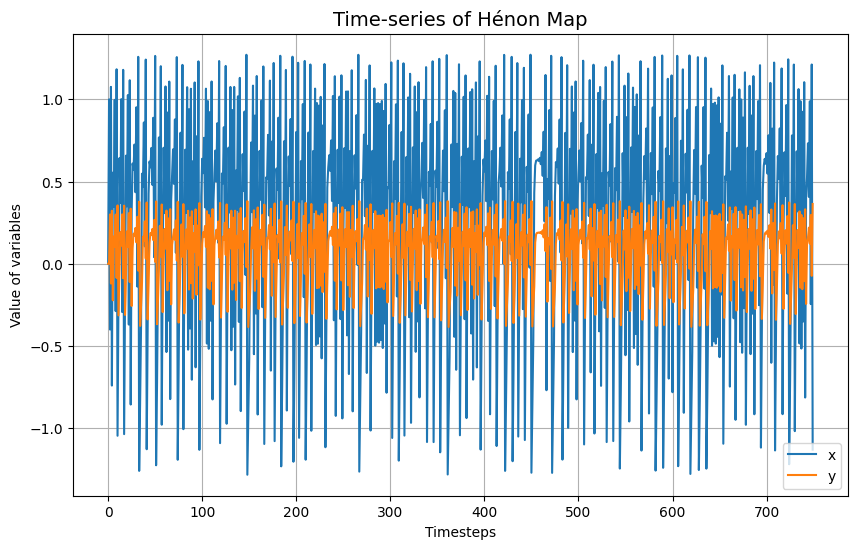

In [354]:
plt.figure(figsize=(10,6))
plt.plot(henon[:750, 0], label='x')
plt.plot(henon[:750, 1], label='y')
plt.xlabel('Timesteps')
plt.ylabel('Value of variables')
plt.grid()
plt.legend(loc='lower right')
plt.title('Time-series of Hénon Map', fontsize=14)

In [383]:
measures = ['Hurst', 'Noise', 'Correlation Dim', 'Lyapunov', 'KS Entropy', 'Fourier']
data = {
    'Measure': measures,
    'Variable X': [
        HurstTraj(henon[:, 0])[2],
        NoiseFactor(henon[:, 0]),
        DimEmb(henon[:, 0])[1],
        max_lyapunov(henon[:, 0]),
        ks_entropy_partition(henon[:, 0]),
        fourier_harmonic_count(henon[:, 0])
    ],
    'Variable Y': [
        HurstTraj(henon[:, 1])[2],
        NoiseFactor(henon[:, 1]),
        DimEmb(henon[:, 1])[1],
        max_lyapunov(henon[:, 1]),
        ks_entropy_partition(henon[:, 1]),
        fourier_harmonic_count(henon[:, 1])
    ]
} 

df = pd.DataFrame(data)
df

,Measure,Variable X,Variable Y
0,Hurst,0.417219,0.406336
1,Noise,0.123438,0.123089
2,Correlation Dim,1.329032,1.328986
3,Lyapunov,0.349080,0.349038
4,KS Entropy,11.384248,11.401011
5,Fourier,1006.000000,1006.000000


In [384]:
round(df,2)

,Measure,Variable X,Variable Y
0,Hurst,0.42,0.41
1,Noise,0.12,0.12
2,Correlation Dim,1.33,1.33
3,Lyapunov,0.35,0.35
4,KS Entropy,11.38,11.40
5,Fourier,1006.00,1006.00


## Prediction

In [355]:
X_train_henon, Y_train_henon, y_test_henon = train_test(henon, 100)

In [388]:
esn_preds = []
esn = reset_esn()

esn.fit(X_train_henon, Y_train_henon)

cur = Y_train_henon[-1]

for i in range(len(y_test_henon)):
    cur = esn.run(cur).flatten()
    esn_preds.append(cur.flatten())

esn_preds = np.vstack(esn_preds)

In [389]:
esn_fan = EnhancedESN_FAN(input_dim=2, reservoir_size=200, spectral_radius=0.9,
                      sparsity=0.1, ridge_alpha=1e-8, poly_order=2, fan_dp=10, seed=23)
esn_fan.fit(X_train_henon, Y_train_henon)

# generative forecast
esn_fan_preds = esn_fan.predict(Y_train_henon, generative_steps=len(y_test_henon))

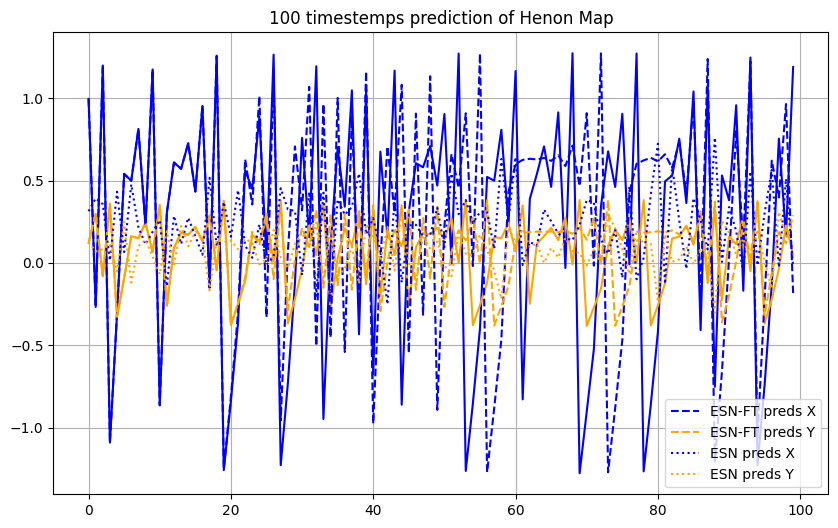

In [390]:
plt.figure(figsize=(10,6))
# real
plt.plot(y_test_henon[:, 0], color='blue')
plt.plot(y_test_henon[:, 1], color='orange')

# esn-f preds
plt.plot(esn_fan_preds[:, 0], label='ESN-FT preds X', ls='--', color='blue')
plt.plot(esn_fan_preds[:, 1], label='ESN-FT preds Y', ls='--', color='orange')

# esn preds
plt.plot(esn_preds[:, 0], label='ESN preds X', ls=':', color='blue')
plt.plot(esn_preds[:, 1], label='ESN preds Y', ls=':', color='orange')

plt.title('100 timestemps prediction of Henon Map')
plt.grid()
plt.legend()

In [376]:
print(f'MAPE X - {round(mean_absolute_percentage_error(y_test_henon[:, 0], esn_preds[:, 0])*100, 2)}, MAE - {round(mean_absolute_error(y_test_henon[:, 0], esn_preds[:, 0]), 2)}')
print(f'MAPE Y - {round(mean_absolute_percentage_error(y_test_henon[:, 1], esn_preds[:, 1])*100, 2)}, MAE - {round(mean_absolute_error(y_test_henon[:, 1], esn_preds[:, 1]), 2)}')


MAPE X - 330.45, MAE - 0.69
MAPE Y - 406.32, MAE - 0.21


In [377]:
print(f'MAPE X - {round(mean_absolute_percentage_error(y_test_henon[:, 0], esn_fan_preds[:, 0])*100, 2)}, MAE - {round(mean_absolute_error(y_test_henon[:, 0], esn_fan_preds[:, 0]), 2)}')
print(f'MAPE Y - {round(mean_absolute_percentage_error(y_test_henon[:, 1], esn_fan_preds[:, 1])*100, 2)}, MAE - {round(mean_absolute_error(y_test_henon[:, 1], esn_fan_preds[:, 1]), 2)}')


MAPE X - 381.77, MAE - 0.56
MAPE Y - 380.61, MAE - 0.16


# Rabinovich

In [24]:
rfab = rabinovich_fabrikant(n_timesteps=3000)

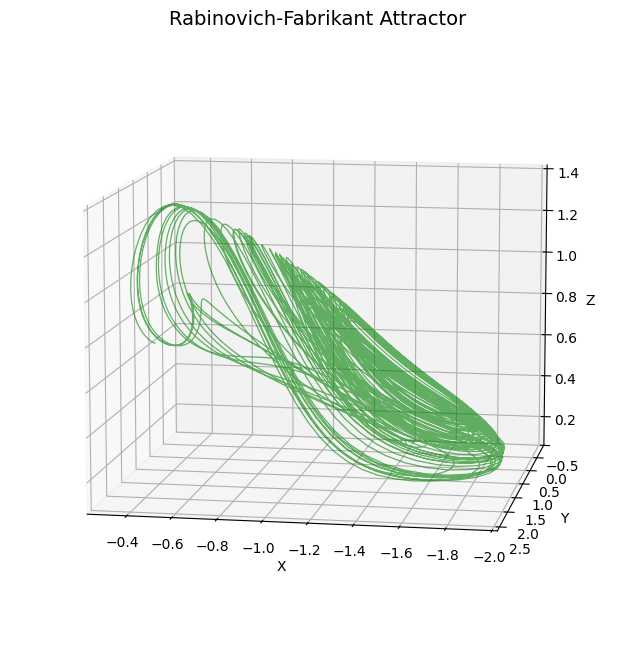

In [25]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(rfab[:, 0], rfab[:, 1], rfab[:, 2], 'g-', lw=0.9, alpha=0.6)
ax.set_title("Rabinovich-Fabrikant Attractor", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=10, azim=100)

Text(0.5, 1.0, 'Time-series of Rabinovich-Fabrikant Attractor')

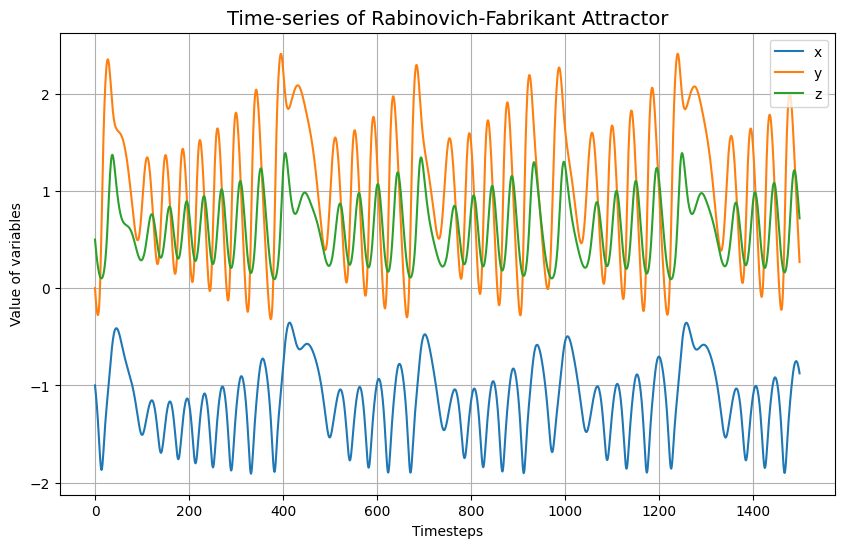

In [26]:
plt.figure(figsize=(10,6))
plt.plot(rfab[:1500, 0], label='x')
plt.plot(rfab[:1500, 1], label='y')
plt.plot(rfab[:1500, 2], label='z')
plt.xlabel('Timesteps')
plt.ylabel('Value of variables')
plt.grid()
plt.legend(loc='upper right')
plt.title('Time-series of Rabinovich-Fabrikant Attractor', fontsize=14)

## Prediction

In [27]:
X_train_rfab, Y_train_rfab, y_test_rfab = train_test(rfab, 100)

In [28]:
esn_preds = []
esn = reset_esn()

esn.fit(X_train_rfab, Y_train_rfab)

cur = Y_train_rfab[-1]

for i in range(len(y_test_rfab)):
    cur = esn.run(cur).flatten()
    esn_preds.append(cur.flatten())

esn_preds = np.vstack(esn_preds)

In [54]:
esn_fan = EnhancedESN_FAN(input_dim=3, reservoir_size=100, spectral_radius=0.9,
                      sparsity=0.1, ridge_alpha=1e-8, poly_order=3, fan_dp=5, seed=23)
esn_fan.fit(X_train_rfab, Y_train_rfab)

# generative forecast
esn_fan_preds = esn_fan.predict(Y_train_rfab, generative_steps=len(y_test_rfab))

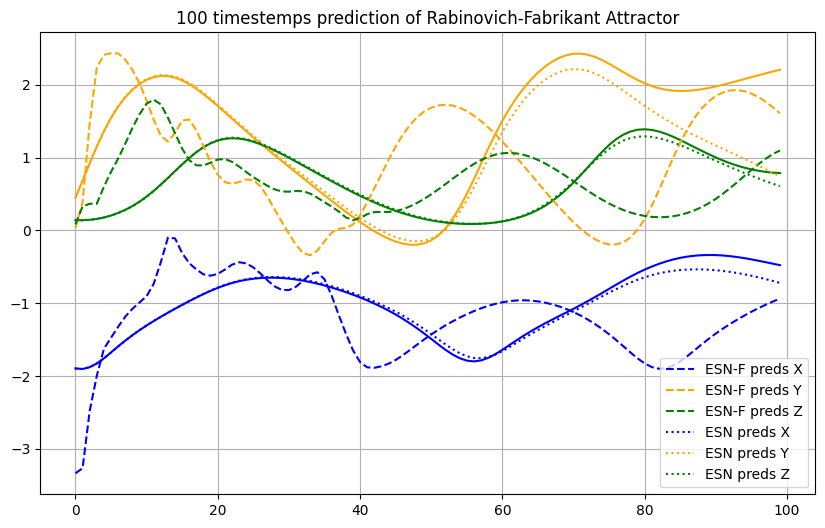

In [55]:
plt.figure(figsize=(10,6))
# real
plt.plot(y_test_rfab[:, 0], color='blue')
plt.plot(y_test_rfab[:, 1], color='orange')
plt.plot(y_test_rfab[:, 2], color='green')

# esn-f preds
plt.plot(esn_fan_preds[:, 0], label='ESN-F preds X', ls='--', color='blue')
plt.plot(esn_fan_preds[:, 1], label='ESN-F preds Y', ls='--', color='orange')
plt.plot(esn_fan_preds[:, 2], label='ESN-F preds Z', ls='--', color='green')

# esn preds
plt.plot(esn_preds[:, 0], label='ESN preds X', ls=':', color='blue')
plt.plot(esn_preds[:, 1], label='ESN preds Y', ls=':', color='orange')
plt.plot(esn_preds[:, 2], label='ESN preds Z', ls=':', color='green')

plt.title('100 timestemps prediction of Rabinovich-Fabrikant Attractor')
plt.grid()
plt.legend()

In [56]:
round(mean_absolute_percentage_error(y_test_rfab, esn_fan_preds), 2)

1.8

In [57]:
round(mean_absolute_percentage_error(y_test_rfab, esn_preds), 2)

0.13

# ESN-F by Reserviorpy

In [310]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

def forward(node, x):
    # Access hyperparameters
    poly_order = node.hypers['poly_order']
    fan_dp = node.hypers['fan_dp']

    # Polynomial features
    poly = PolynomialFeatures(degree=poly_order, include_bias=False)
    poly_features = poly.fit_transform(x)

    # Fourier features
    features = []
    for k in range(1, fan_dp + 1):
        features.append(np.sin(2 * np.pi * k * x))
        features.append(np.cos(2 * np.pi * k * x))
    fourier_features = np.hstack(features)

    # Combine features
    combined = np.hstack([poly_features, fourier_features])

    return combined

def initialize(node, x=None, y=None):
    if x is not None:
        node.set_input_dim(x.shape[1])
        # Calculate output dimension: poly features + Fourier features
        poly_order = node.hypers['poly_order']
        fan_dp = node.hypers['fan_dp']
        poly = PolynomialFeatures(degree=poly_order, include_bias=False)
        poly_features = poly.fit_transform(x)
        fourier_features = 2 * fan_dp * x.shape[1]
        total_features = poly_features.shape[1] + fourier_features
        node.set_output_dim(total_features)

from reservoirpy import Node

enhanced_features_node = Node(
    # name="EnhancedFeatures",
    forward=forward,
    initializer=initialize,
    params={},
    hypers={'poly_order': 5, 'fan_dp': 10}
)

from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units=200, lr=0.3, sr=0.9)
readout = Ridge(ridge=1e-8)

# Connect the nodes
model = enhanced_features_node >> reservoir >> readout


model.fit(X_train_rossler[500:], Y_train_rossler[500:])

# Closed-loop forecasting:
future_steps = 100
preds = model.run(Y_train_rossler[-1])
predictions = [preds]

for _ in range(future_steps - 1):
    preds = model.run(preds)
    predictions.append(preds)

predictions = np.vstack(predictions)

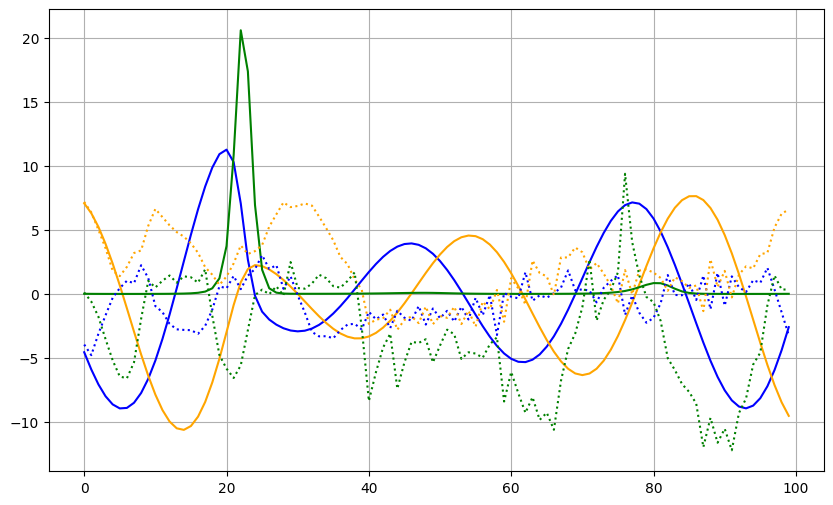

In [311]:
plt.figure(figsize=(10,6))
# real
plt.plot(y_test_rossler[:, 0], color='blue')
plt.plot(y_test_rossler[:, 1], color='orange')
plt.plot(y_test_rossler[:, 2], color='green')

plt.plot(predictions[:, 0], color='blue', ls=':')
plt.plot(predictions[:, 1], color='orange', ls=':')
plt.plot(predictions[:, 2], color='green', ls=':')

plt.grid()

In [283]:
HurstTraj(X_train_rossler[:, 2])[2]

np.float64(0.6966825254408147)